In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st  # Nếu bạn sử dụng Streamlit
import datetime
import matplotlib.cm as cm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import ngrams


In [3]:
raw_path = r"D:\PRO229-DATN\BrazilSalesData\Data\\"

olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
product_category_translation = pd.read_csv(raw_path + 'product_category_name_translation.csv')

df_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
df_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
df_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
df_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
df_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
df_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')
df_order_pay = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
df_customers = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
df_category = pd.read_csv(raw_path + 'product_category_name_translation.csv')


In [4]:
olist_orders['order_purchase_timestamp'] = pd.to_datetime(olist_orders['order_purchase_timestamp'])
olist_orders['order_delivered_customer_date'] = pd.to_datetime(olist_orders['order_delivered_customer_date'])
olist_orders['order_estimated_delivery_date'] = pd.to_datetime(olist_orders['order_estimated_delivery_date'])
olist_orders['order_delivered_carrier_date'] = pd.to_datetime(olist_orders['order_delivered_carrier_date'])

#thời gian vận chuyển
olist_orders['Shipping Days'] = (olist_orders['order_delivered_customer_date'] - olist_orders['order_delivered_carrier_date']).dt.days

# Hàm xác định trạng thái giao hàng
def Delivery_status(row):
    day_diff = row['order_estimated_delivery_date'] - row['order_delivered_customer_date']
    return 'On time' if day_diff.days >= 0 else 'Late'

olist_orders['delivery_status'] = olist_orders.apply(Delivery_status, axis=1)

#các hóa đơn có tồn tại trong bảng order_items
olist_orders = olist_orders[olist_orders['order_id'].isin(olist_order_items['order_id'])]


In [5]:
sales = olist_order_items[olist_order_items['order_id'].isin(olist_orders['order_id'])]
sales = sales.merge(olist_orders[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'Shipping Days', 'delivery_status']], on='order_id')
sales = sales.merge(olist_customer[['customer_id', 'customer_city', 'customer_state']], on='customer_id', how='left')
sales = sales.merge(olist_sellers[['seller_id', 'seller_city', 'seller_state']], on='seller_id', how='left')

# Kết hợp bảng product và product_category_translation
product = pd.merge(olist_products, product_category_translation, on='product_category_name', how='left')
product.fillna('Unknows', inplace=True)
sales = sales.merge(product[['product_category_name', 'product_id']], on='product_id', how='left')

#doanh thu
sales['revenue'] = sales['price'] * sales['order_item_id']
total_sales = sales['revenue'].sum()
print("Total Sales:", "${:,.2f}".format(total_sales))


Total Sales: $15,397,738.61


C:\Users\duydu\AppData\Local\Temp\ipykernel_17224\1837402854.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknows' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  product.fillna('Unknows', inplace=True)


C:\Users\duydu\AppData\Local\Temp\ipykernel_17224\3715570070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='coolwarm')


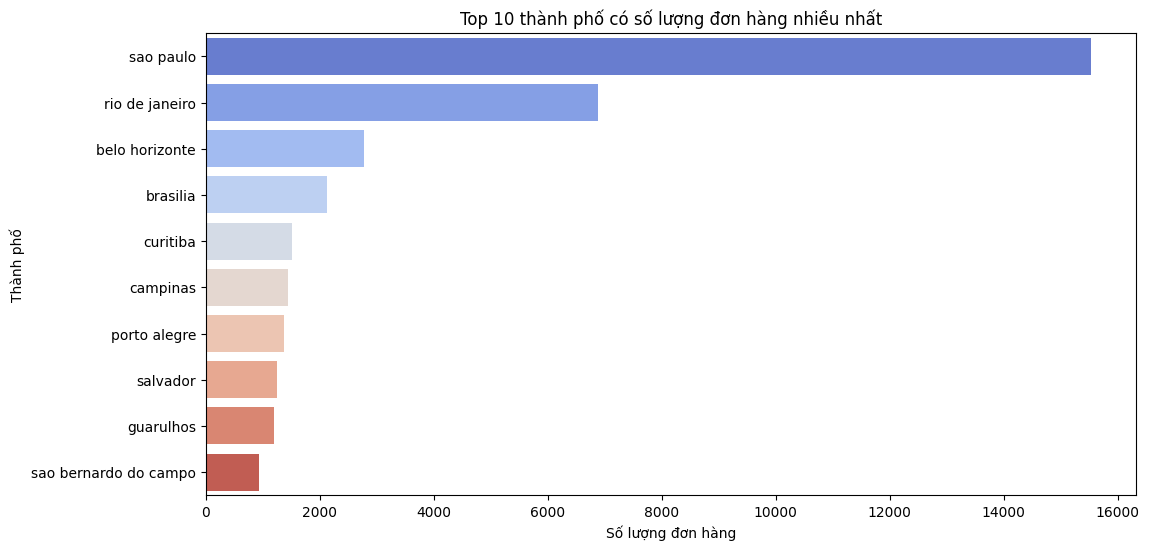

In [7]:
top_cities = df_customers['customer_city'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.values, y=top_cities.index, palette='coolwarm')
plt.title('Top 10 thành phố có số lượng đơn hàng nhiều nhất')
plt.xlabel('Số lượng đơn hàng')
plt.ylabel('Thành phố')
plt.show()


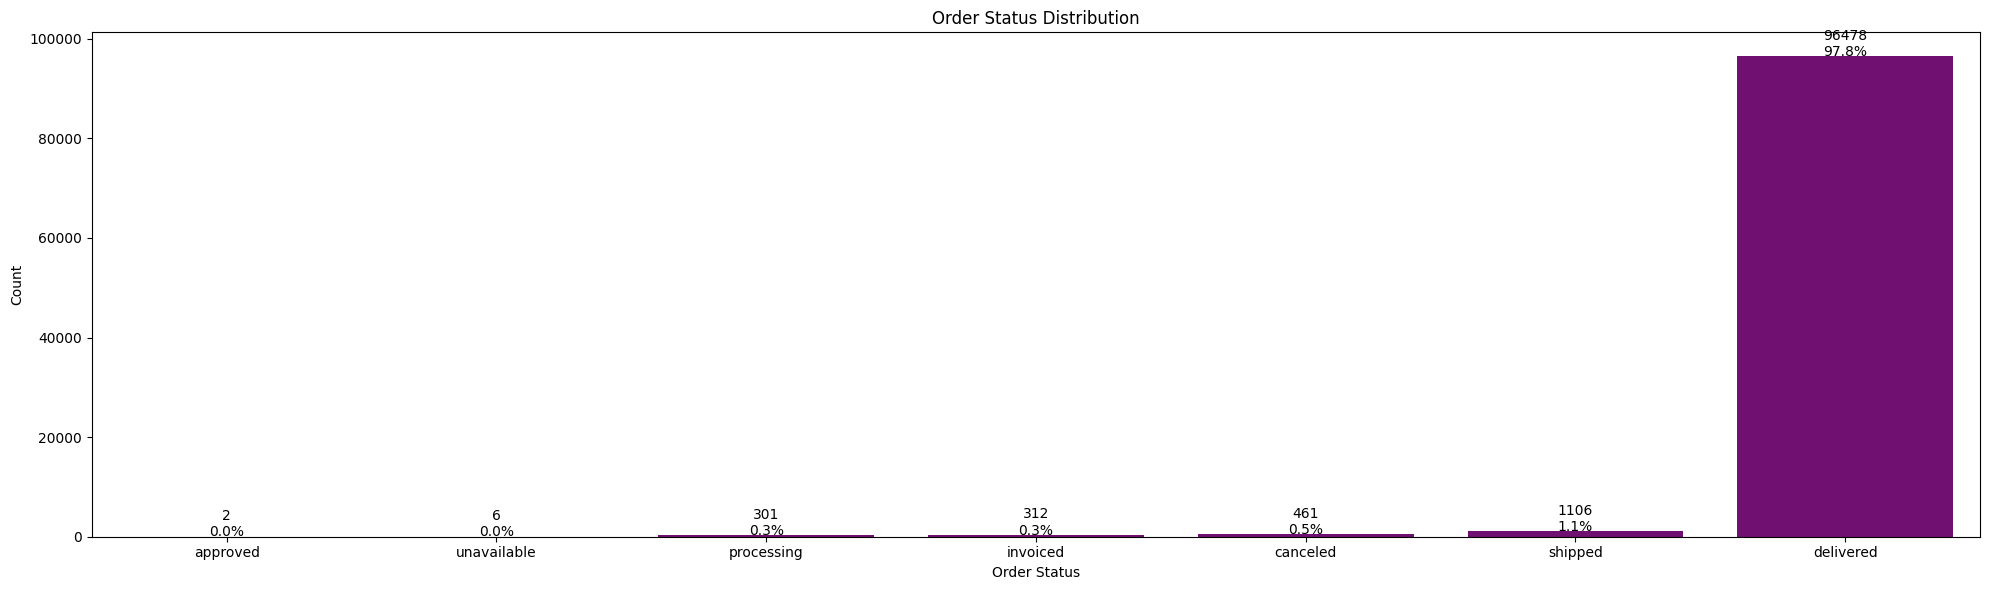

In [ ]:
order_status = olist_orders.groupby('order_status')['order_id'].count().sort_values()
plt.figure(figsize=(20, 6))
ax = sns.barplot(x=order_status.index, y=order_status.values.astype(int), color='purple')
for i, value in enumerate(order_status.values):
    percentage = (value / order_status.sum()) * 100
    ax.text(i, value + 100, f'{value}\n{percentage:.1f}%', ha='center', color='black')
plt.xlabel('Order Status')
plt.ylabel('Count')
plt.title('Order Status Distribution')
plt.tight_layout()
plt.show()


In [ ]:
df = df_orders.merge(df_items, on='order_id', how='inner')
df = df.merge(df_order_pay, on='order_id', how='inner', validate='m:m')
df = df.merge(df_reviews, on='order_id', how='inner')
df = df.merge(df_products, on='product_id', how='inner')
df = df.merge(df_customers, on='customer_id', how='inner')
df = df.merge(df_sellers, on='seller_id', how='inner')

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])


In [ ]:
#tạo các feature thời gian
df['day_of_week_int'] = df['order_purchase_timestamp'].dt.weekday + 1
df['hour'] = df['order_purchase_timestamp'].dt.hour
df['month'] = df['order_purchase_timestamp'].dt.month
df['year'] = df['order_purchase_timestamp'].dt.year
df['date'] = df['order_purchase_timestamp'].dt.to_period('M')
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days


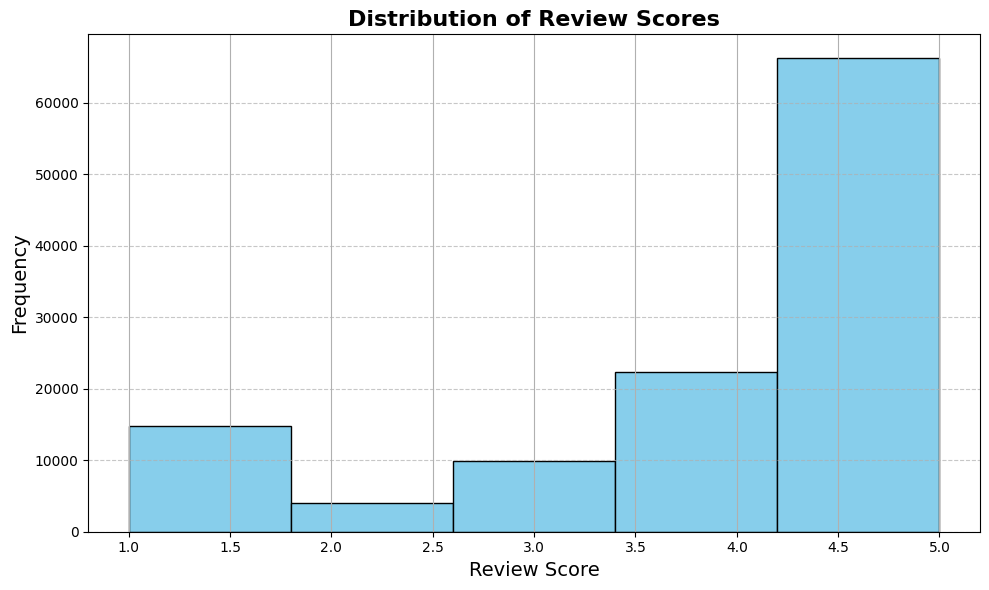

In [ ]:
plt.figure(figsize=(10, 6))
df['review_score'].hist(bins=5, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Scores', fontsize=16, fontweight='bold')
plt.xlabel('Review Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
df_merged = pd.merge(df_items, df_products, on='product_id', how='inner')
product_revenue = df_merged.groupby('product_category_name')['price'].sum().sort_values(ascending=False)
print(product_revenue.head())


product_category_name
beleza_saude              1258681.34
relogios_presentes        1205005.68
cama_mesa_banho           1036988.68
esporte_lazer              988048.97
informatica_acessorios     911954.32
Name: price, dtype: float64


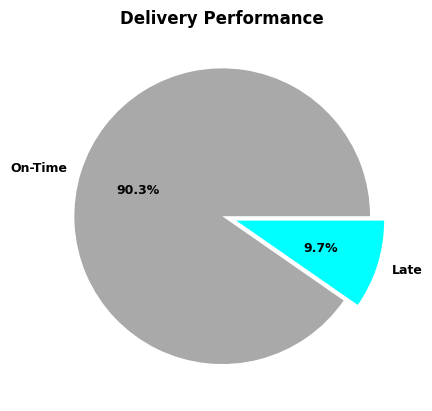

In [ ]:
df['on_time'] = np.where(df['order_delivered_customer_date'] <= df['order_estimated_delivery_date'], 'on_time', 'late')
delivery_counts = df['on_time'].value_counts()
labels = ['On-Time', 'Late']
explode = (0, 0.1)
colors = ['darkgray', 'aqua']

plt.pie(delivery_counts, colors=colors, explode=explode, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 9, 'fontweight': 'bold'})
plt.title('Delivery Performance', fontweight='bold')
plt.show()

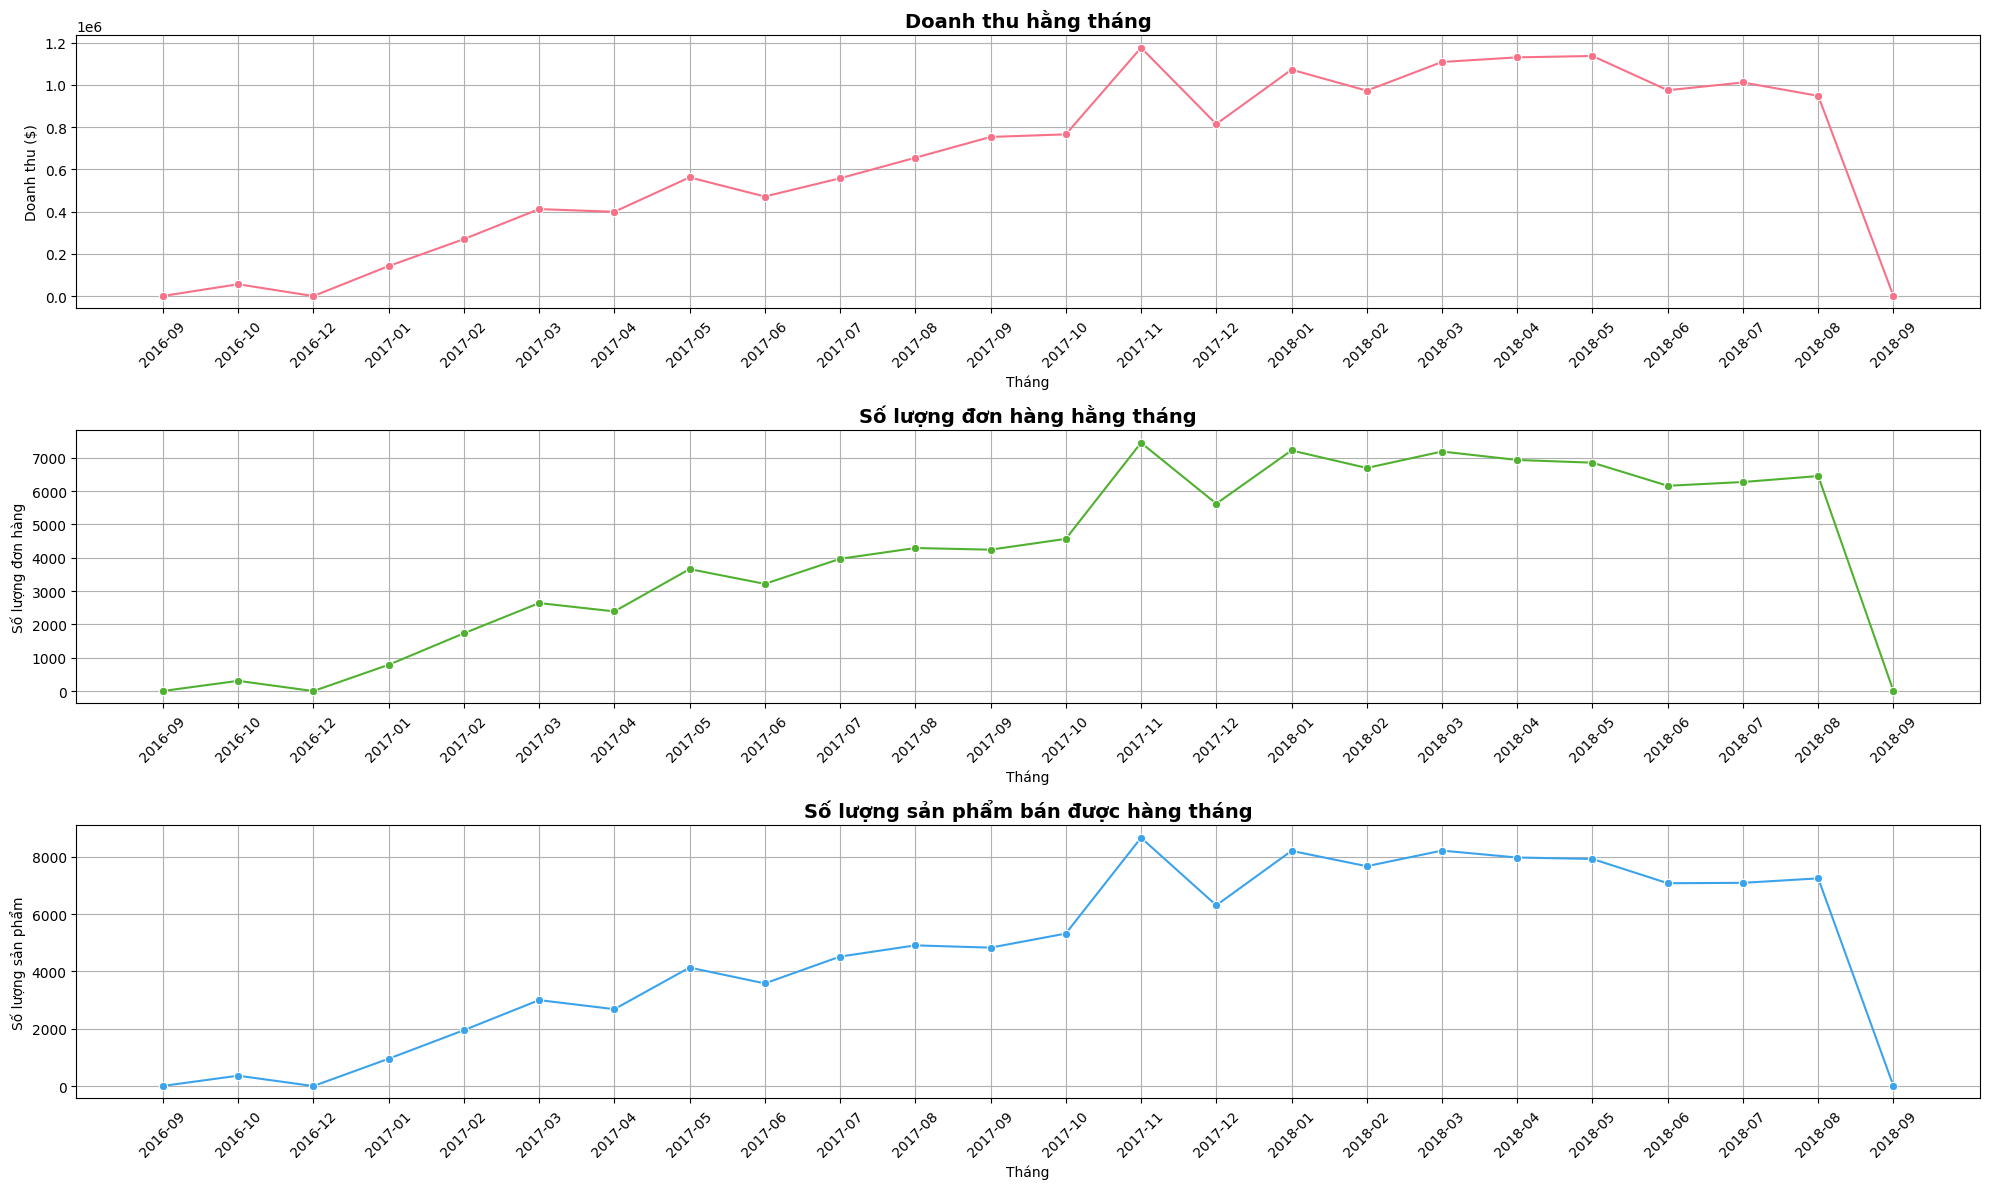

In [ ]:

sales['order_month'] = sales['order_purchase_timestamp'].dt.to_period('M')

#nhóm dữ liệu theo tháng
sales_by_month = sales.groupby('order_month').agg({
    'revenue': 'sum',  # Tổng doanh thu
    'order_id': 'nunique',  # Số lượng đơn hàng
    'product_id': 'count'  # Số lượng sản phẩm bán được
}).reset_index()

sales_by_month.rename(columns={'order_id': 'order_count', 'product_id': 'product_count'}, inplace=True)
sales_by_month['order_month'] = sales_by_month['order_month'].astype(str)

fig, axs = plt.subplots(3, 1, figsize=(20, 12))

palette = sns.color_palette("husl", 3)  # 3 màu sắc khác nhau

#oanh thu hàng tháng
sns.lineplot(x='order_month', y='revenue', data=sales_by_month, marker='o', ax=axs[0], color=palette[0])
axs[0].set_title('Doanh thu hằng tháng', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Tháng')
axs[0].set_ylabel('Doanh thu ($)')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

#số lượng đơn hàng hằng tháng
sns.lineplot(x='order_month', y='order_count', data=sales_by_month, marker='o', ax=axs[1], color=palette[1])
axs[1].set_title('Số lượng đơn hàng hằng tháng', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Tháng')
axs[1].set_ylabel('Số lượng đơn hàng')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

#số lượng sản phẩm bán được hàng tháng
sns.lineplot(x='order_month', y='product_count', data=sales_by_month, marker='o', ax=axs[2], color=palette[2])
axs[2].set_title('Số lượng sản phẩm bán được hàng tháng', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Tháng')
axs[2].set_ylabel('Số lượng sản phẩm')
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

plt.tight_layout()
plt.show()


C:\Users\duydu\AppData\Local\Temp\ipykernel_3528\2149669433.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




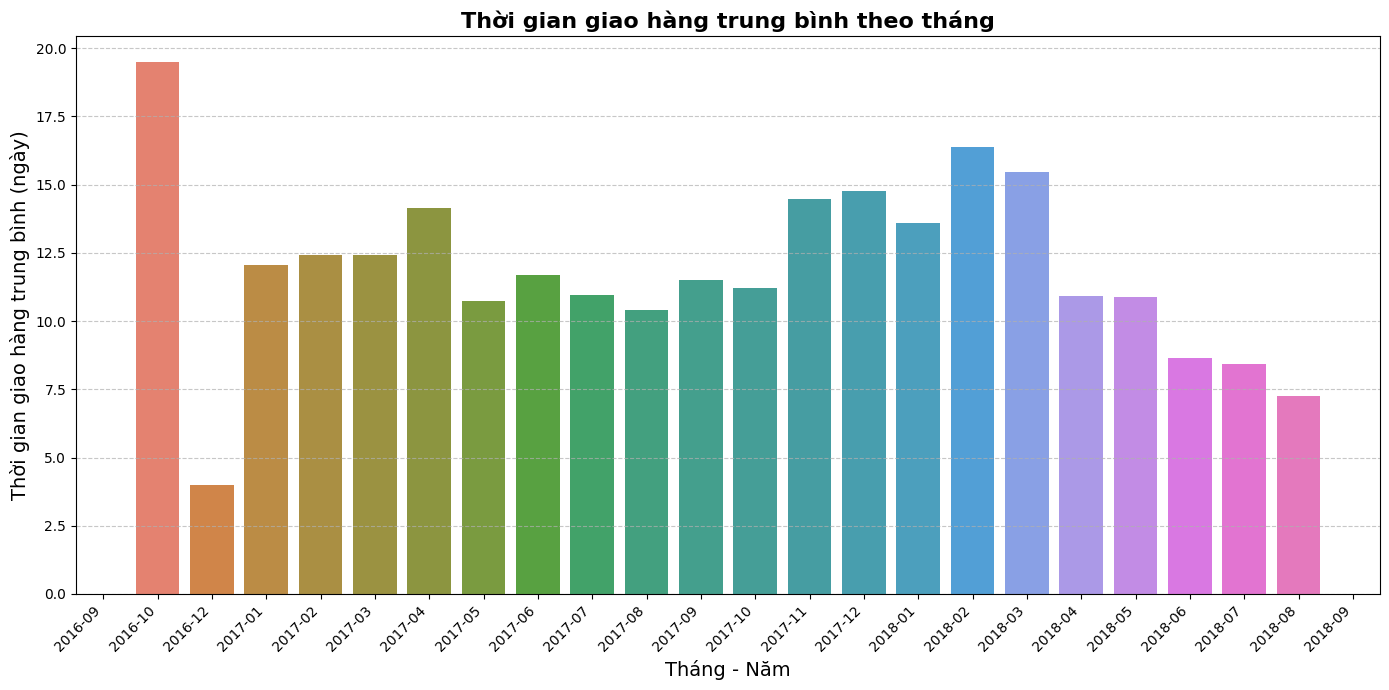

In [ ]:
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)

# thời gian giao hàng trung bình theo từng tháng
monthly_delivery_time = df.groupby('month_year', as_index=False)['delivery_time'].mean()

colors = sns.color_palette("husl", len(monthly_delivery_time))

plt.figure(figsize=(14, 7))
sns.barplot(x='month_year', y='delivery_time', data=monthly_delivery_time, palette=colors)

plt.title('Thời gian giao hàng trung bình theo tháng', fontsize=16, fontweight='bold')
plt.xlabel('Tháng - Năm', fontsize=14)
plt.ylabel('Thời gian giao hàng trung bình (ngày)', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


C:\Users\duydu\AppData\Local\Temp\ipykernel_3528\1945060795.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




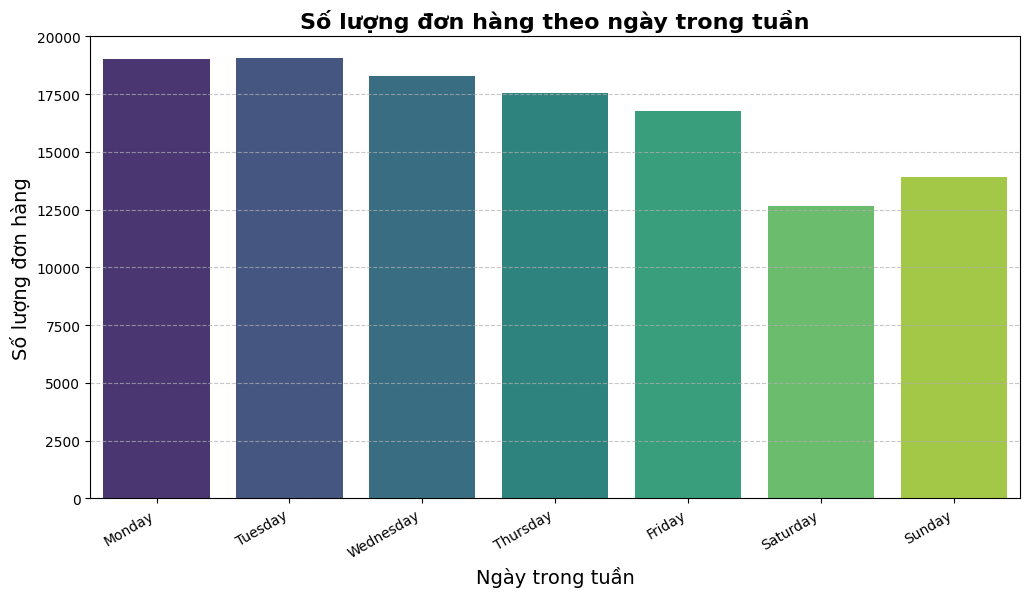

In [ ]:
#thứ tự ngày trong tuần
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Tạo cột ngày trong tuần từ order_purchase_timestamp
df['day_of_week'] = df['order_purchase_timestamp'].dt.day_name()

#số lượng đơn hàng theo từng ngày trong tuần
order_count_by_day = df['day_of_week'].value_counts().reindex(day_order)

plt.figure(figsize=(12, 6))
sns.barplot(x=order_count_by_day.index, y=order_count_by_day.values, palette='viridis')

plt.title('Số lượng đơn hàng theo ngày trong tuần', fontsize=16, fontweight='bold')
plt.xlabel('Ngày trong tuần', fontsize=14)
plt.ylabel('Số lượng đơn hàng', fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

#thời gian phê duyệt (giờ)
df['time_to_approve'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600

#thời gian giao hàng (giờ)
df['time_to_deliver'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600

df = df.dropna(subset=['time_to_approve', 'time_to_deliver'])


NameError: name 'pd' is not defined

In [ ]:
from sklearn.cluster import KMeans

#số cụm
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df[['time_to_approve', 'time_to_deliver']])

performance_df = df[['time_to_approve', 'time_to_deliver', 'Cluster']]


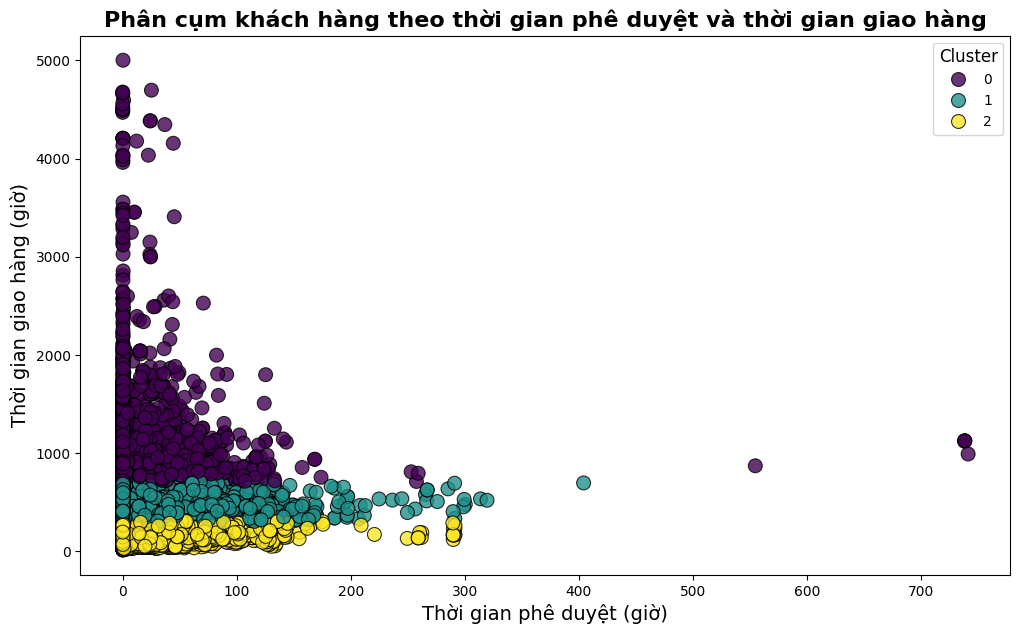

In [ ]:
performance_df = performance_df.dropna(subset=['time_to_approve', 'time_to_deliver', 'Cluster'])

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=performance_df,
    x='time_to_approve', 
    y='time_to_deliver', 
    hue='Cluster', 
    palette='viridis',
    s=100,  # Kích thước điểm
    edgecolor='black',  # Viền đen để phân biệt điểm
    alpha=0.8  # Độ trong suốt để tránh che khuất dữ liệu
)

plt.title('Phân cụm khách hàng theo thời gian phê duyệt và thời gian giao hàng', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian phê duyệt (giờ)', fontsize=14)
plt.ylabel('Thời gian giao hàng (giờ)', fontsize=14)

plt.legend(title='Cluster', title_fontsize=12, fontsize=10)

plt.show()


In [ ]:
#thêm freight_value vào performance_df
performance_df = df[['time_to_approve', 'time_to_deliver', 'freight_value', 'Cluster']].dropna()


C:\Users\duydu\AppData\Local\Temp\ipykernel_3528\1870434559.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\duydu\AppData\Local\Temp\ipykernel_3528\1870434559.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\duydu\AppData\Local\Temp\ipykernel_3528\1870434559.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




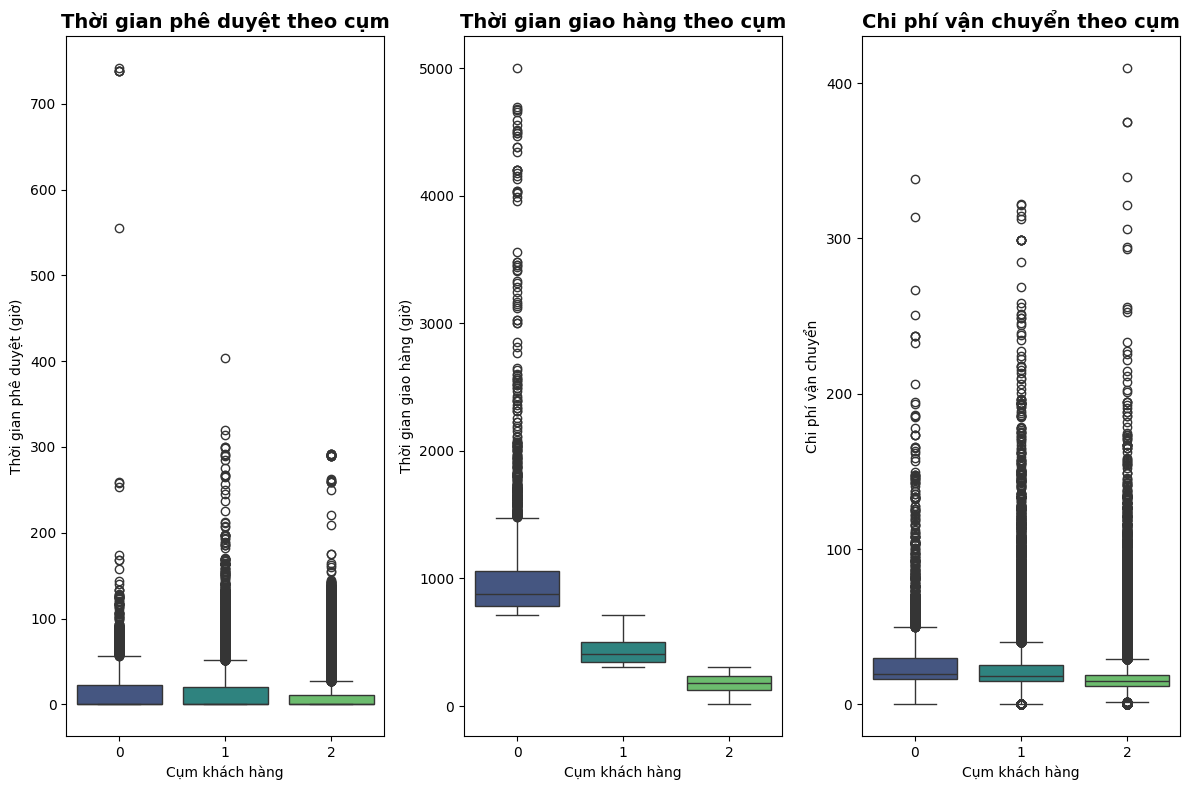

In [ ]:
plt.figure(figsize=(12, 8))

# 'time_to_approve'
plt.subplot(1, 3, 1)
sns.boxplot(data=performance_df, x='Cluster', y='time_to_approve', palette='viridis')
plt.title('Thời gian phê duyệt theo cụm', fontsize=14, fontweight='bold')
plt.xlabel('Cụm khách hàng')
plt.ylabel('Thời gian phê duyệt (giờ)')

# 'time_to_deliver'
plt.subplot(1, 3, 2)
sns.boxplot(data=performance_df, x='Cluster', y='time_to_deliver', palette='viridis')
plt.title('Thời gian giao hàng theo cụm', fontsize=14, fontweight='bold')
plt.xlabel('Cụm khách hàng')
plt.ylabel('Thời gian giao hàng (giờ)')

# 'freight_value'
plt.subplot(1, 3, 3)
sns.boxplot(data=performance_df, x='Cluster', y='freight_value', palette='viridis')
plt.title('Chi phí vận chuyển theo cụm', fontsize=14, fontweight='bold')
plt.xlabel('Cụm khách hàng')
plt.ylabel('Chi phí vận chuyển')

plt.tight_layout()
plt.show()


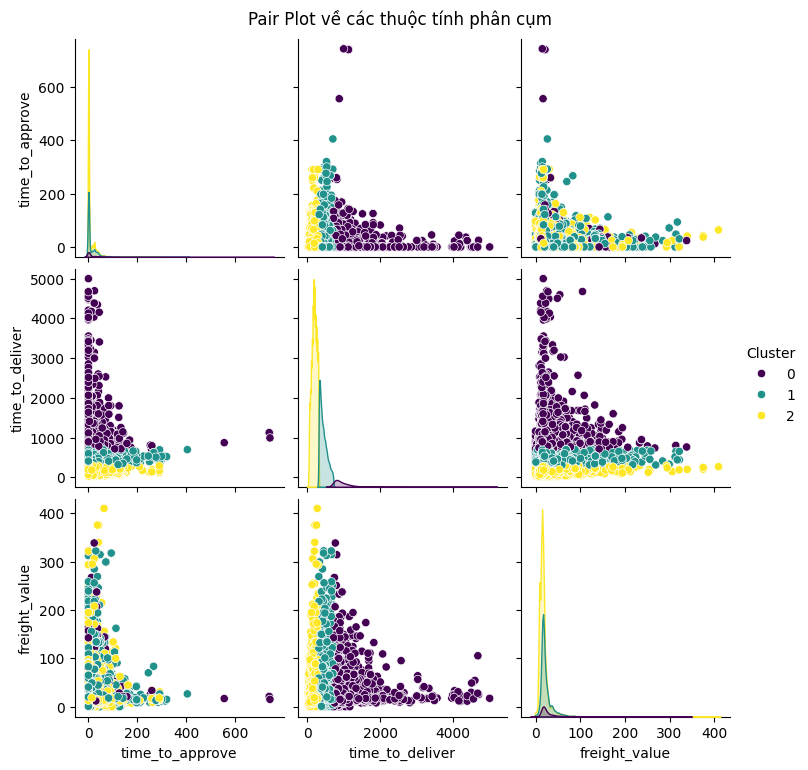

In [ ]:
sns.pairplot(performance_df, vars=['time_to_approve', 'time_to_deliver', 'freight_value'], hue='Cluster', palette='viridis', diag_kind='kde', height=2.5)
plt.suptitle('Pair Plot về các thuộc tính phân cụm', y=1.02)
plt.show()


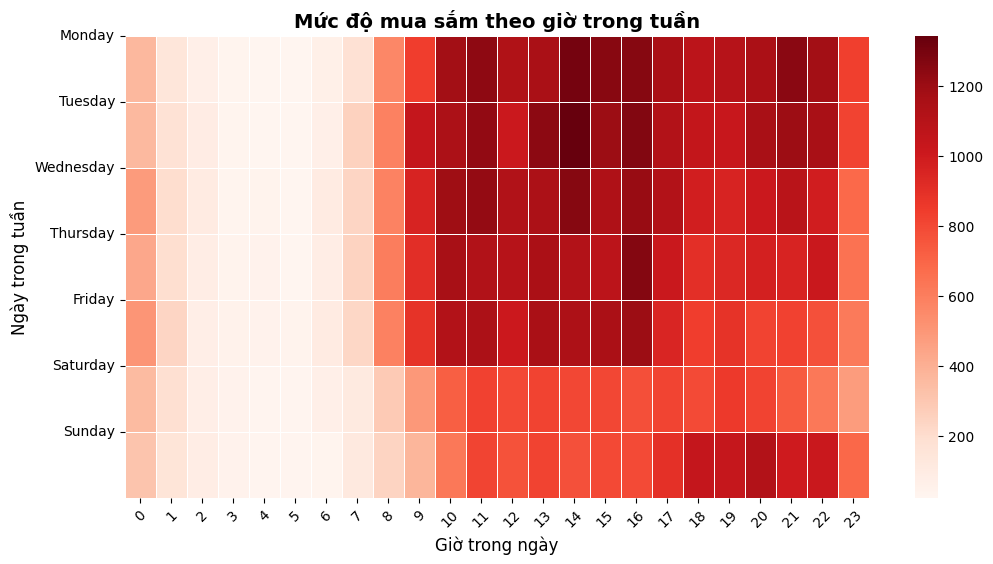

In [ ]:
#giờ và ngày trong tuần
df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour
df['purchase_day'] = df['order_purchase_timestamp'].dt.dayofweek  # 0: Monday, 6: Sunday

#số lượng đơn hàng theo giờ và ngày trong tuần
heatmap_data = df.groupby(['purchase_day', 'purchase_hour']).size().unstack()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, cbar=True, annot=False)

plt.title('Mức độ mua sắm theo giờ trong tuần', fontsize=14, fontweight='bold')
plt.xlabel('Giờ trong ngày', fontsize=12)
plt.ylabel('Ngày trong tuần', fontsize=12)
plt.yticks(ticks=range(7), labels=days, rotation=0)  # Gán nhãn cho trục Y
plt.xticks(rotation=45)

plt.show()



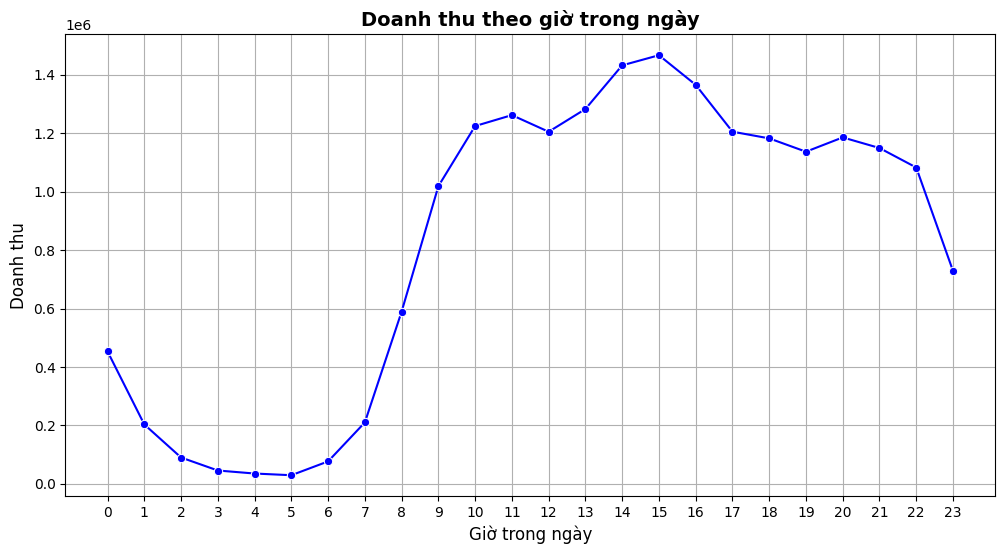

In [ ]:
plt.figure(figsize=(12, 6))
hourly_revenue = df.groupby(df['order_purchase_timestamp'].dt.hour)['payment_value'].sum()
sns.lineplot(x=hourly_revenue.index, y=hourly_revenue.values, marker='o', color='b')
plt.title('Doanh thu theo giờ trong ngày', fontsize=14, fontweight='bold')
plt.xlabel('Giờ trong ngày', fontsize=12)
plt.ylabel('Doanh thu', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


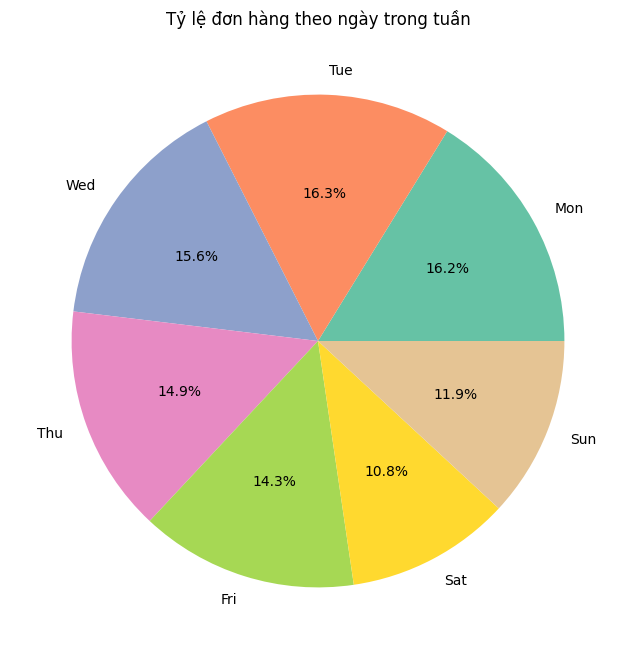

In [ ]:
plt.figure(figsize=(8, 8))
order_by_day = df['order_purchase_timestamp'].dt.dayofweek.value_counts().sort_index()
plt.pie(order_by_day, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], autopct='%1.1f%%', colors=sns.color_palette("Set2"))
plt.title('Tỷ lệ đơn hàng theo ngày trong tuần')
plt.show()


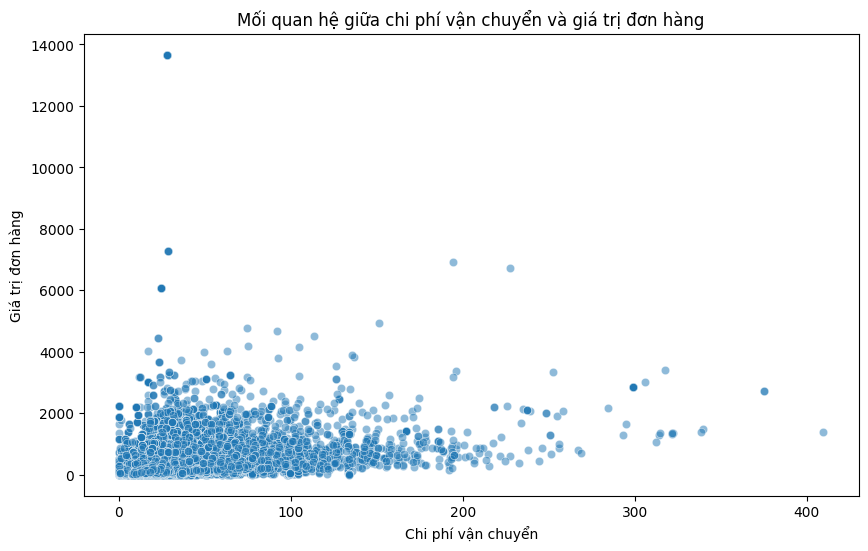

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='freight_value', y='payment_value', data=df, alpha=0.5)
plt.title('Mối quan hệ giữa chi phí vận chuyển và giá trị đơn hàng')
plt.xlabel('Chi phí vận chuyển')
plt.ylabel('Giá trị đơn hàng')
plt.show()
